In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Dynamic Standard Theta Model

> Step-by-step guide on using the `DynamicStandardTheta Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Dynamic Standard Theta Model (DOTM)](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of DynamicStandardTheta with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Dynamic Standard Theta Models (DSTM) <a class="anchor" id="model"></a>

The Dynamic Standard Theta Model is a case-specific variation of the [Optimized Dynamic Theta Model](./DynamicOptimizedTheta.ipynb).

Also, for $\theta=2$, we have a stochastic approach of Theta, which is referred to hereafter as the dynamic standard Theta model (DSTM).

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/milk_production.csv", usecols=[1,2])
df.head()

,month,production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1962-01-01,589,1
1,1962-02-01,561,1
2,1962-03-01,640,1
3,1962-04-01,656,1
4,1962-05-01,727,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

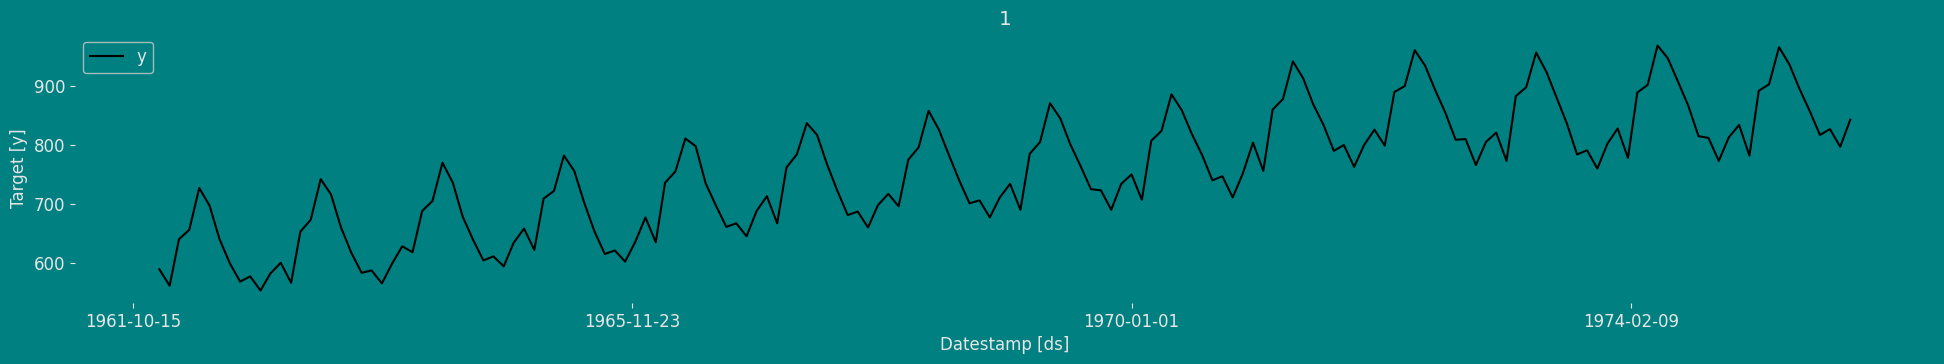

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

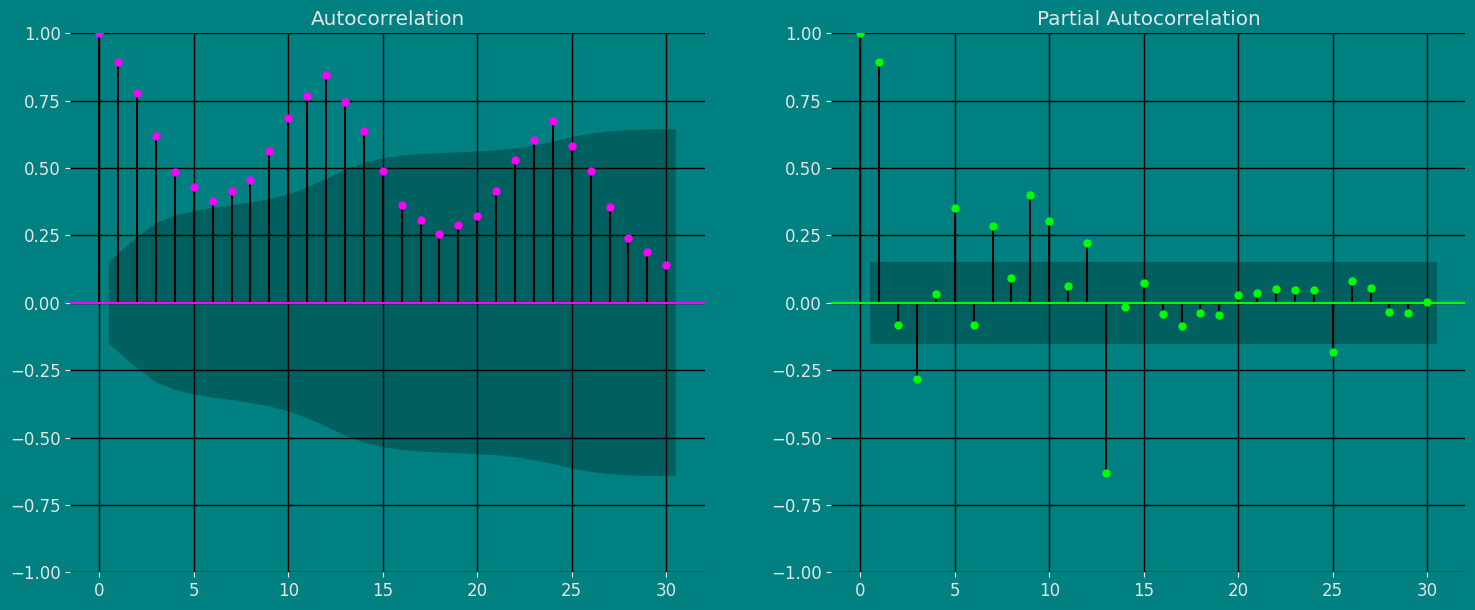

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

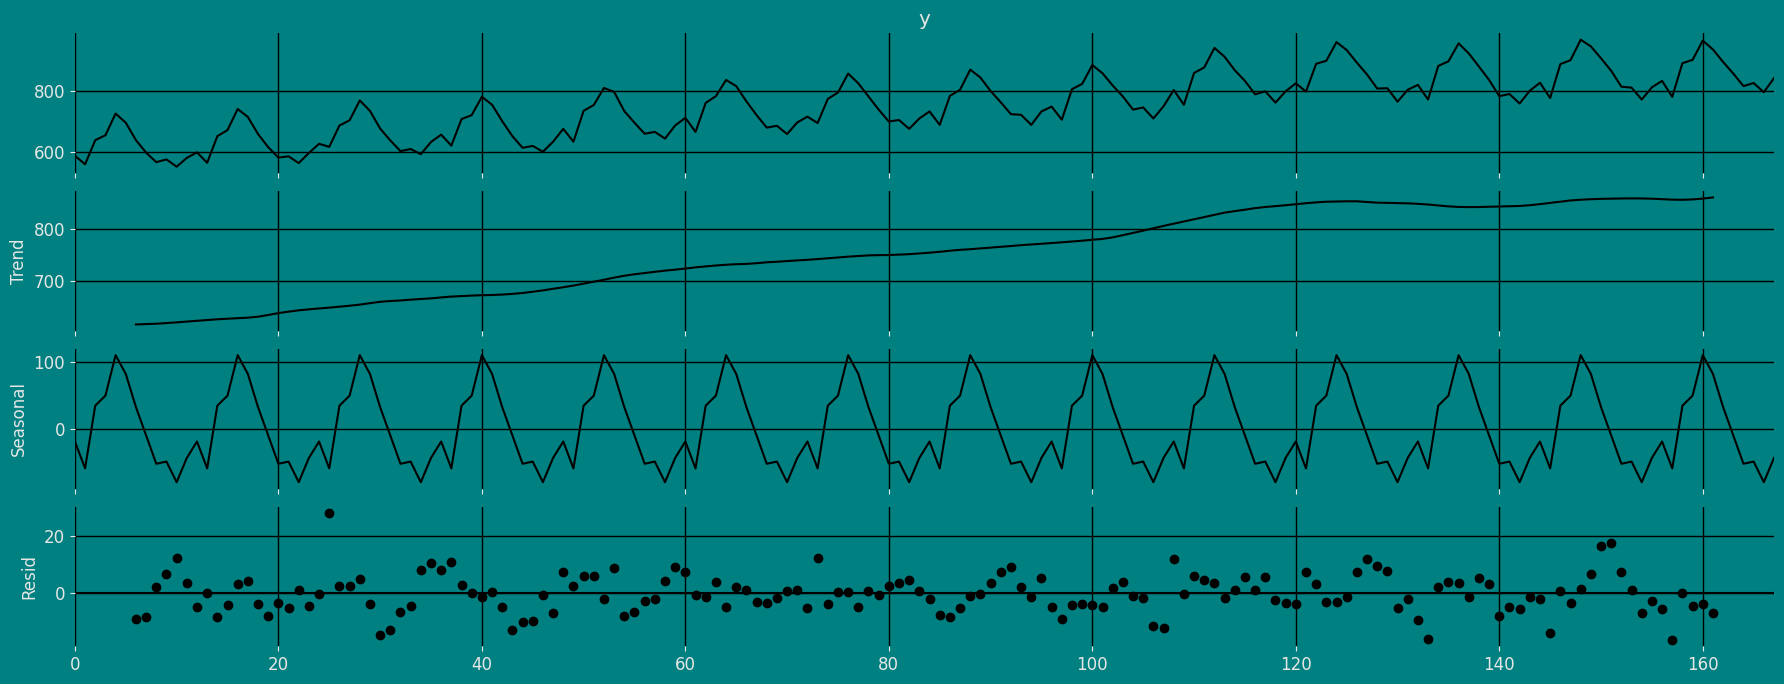

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

### Multiplicative

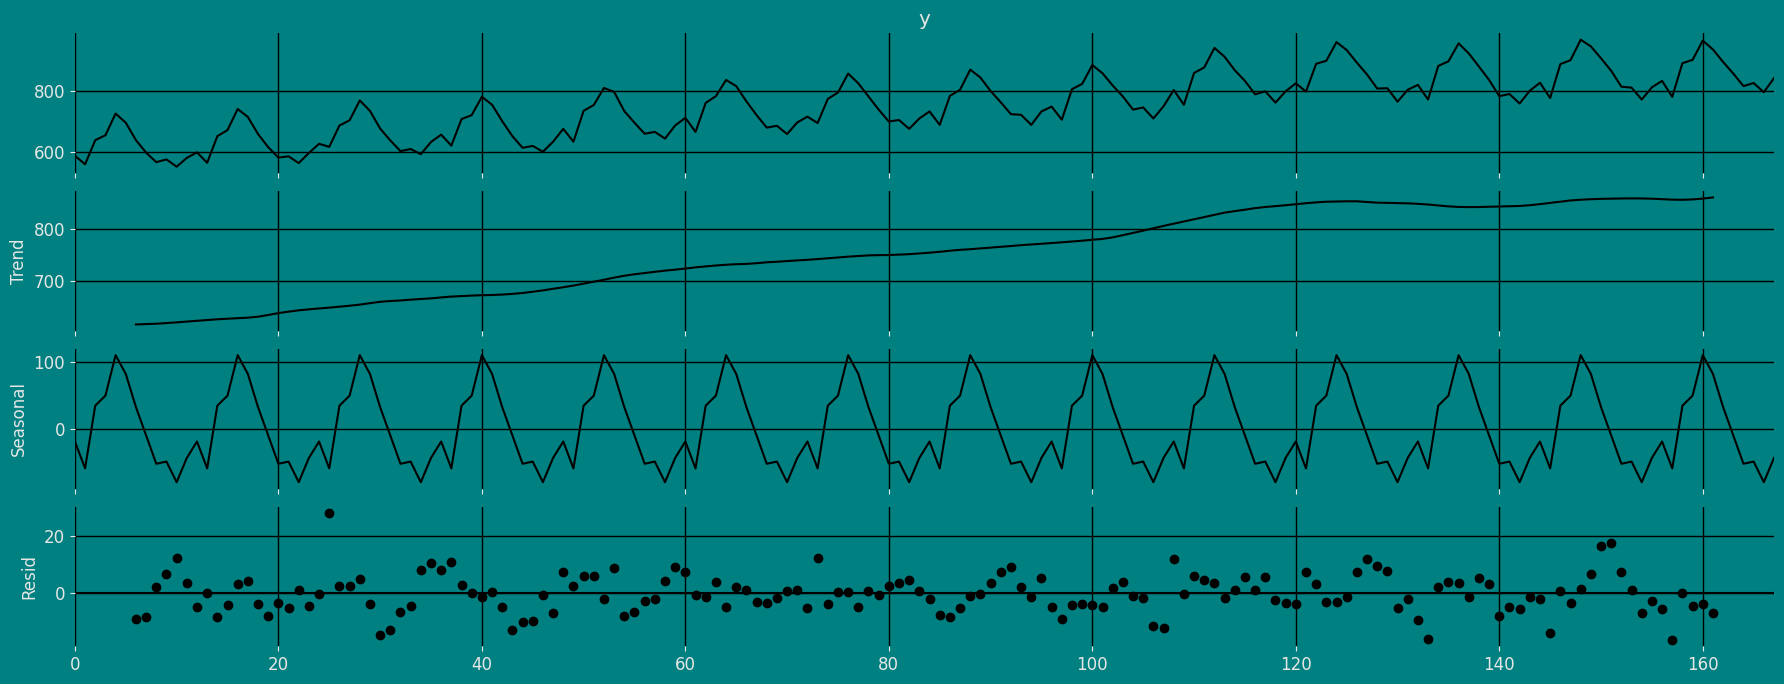

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "Multiplicative", period=12)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `Dynamic Standard Theta Model`
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='1974-12-01'] 
test = df[df.ds>'1974-12-01'] 

In [ ]:
train.shape, test.shape

((156, 3), (12, 3))

Now let's plot the training data and the test data.

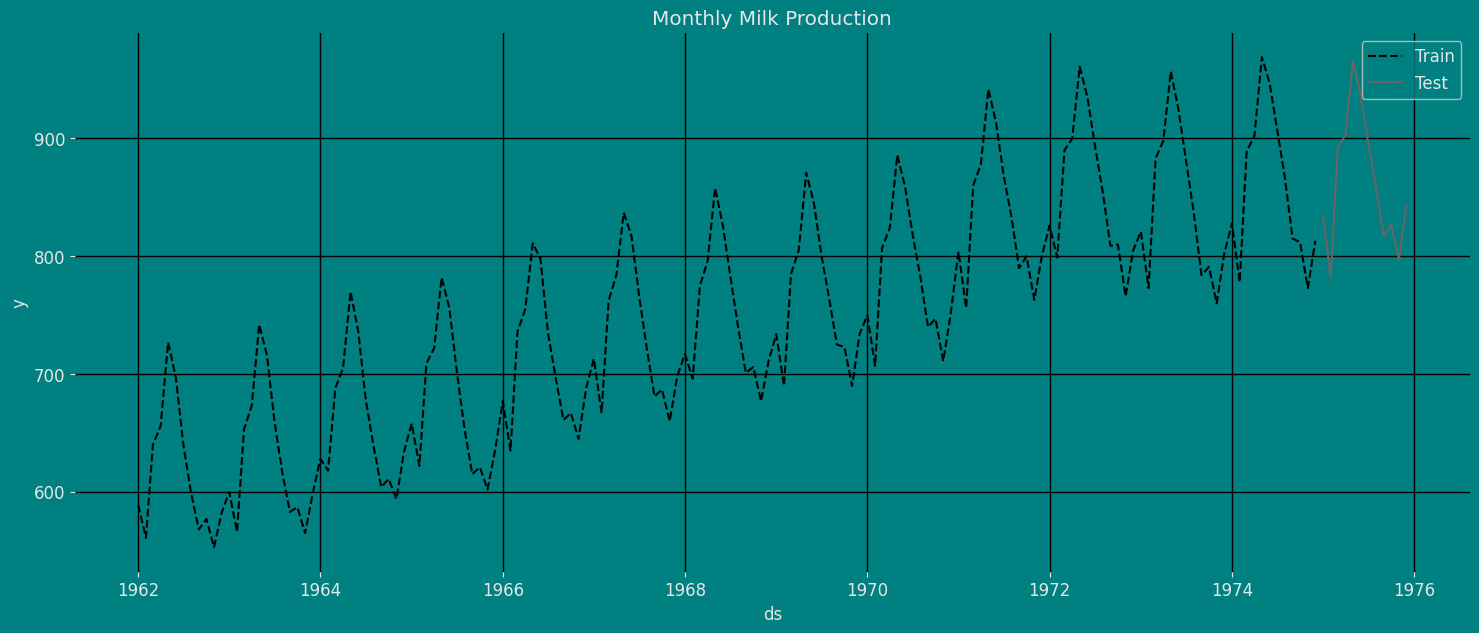

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Monthly Milk Production")
plt.show()

## Implementation of DynamicStandardTheta with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `DynamicStandardTheta Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#dynamicstandardtheta).

```
season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.
decomposition_type : str
    Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
alias : str
    Custom name of the model.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import DynamicTheta

### Instantiating Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.


In [ ]:
season_length = 12 # Monthly data 
horizon = len(test) # number of predictions

models = [DynamicTheta(season_length=season_length, 
                decomposition_type="additive")] # multiplicative additive

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='MS', 
                   n_jobs=-1)

### Fit Model

In [ ]:
sf.fit()

StatsForecast(models=[DynamicTheta])

Let's see the results of our `Dynamic Standard Theta model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mse': 10.789180969422018,
 'amse': array([ 54.80024565,  86.05803568, 116.12121576]),
 'fit': results(x=array([393.28739991,   0.76875   ]), fn=10.787112115489615, nit=20, simplex=array([[399.92916541,   0.771875  ],
        [393.28739991,   0.76875   ],
        [384.74798713,   0.771875  ]])),
 'residuals': array([-18.24713135, -46.24713135,  17.14019775,  49.01220703,
        121.9788208 ,  82.67987061,  25.4487915 , -11.09313965,
        -42.07873535, -41.60479736, -71.8616333 , -49.2645874 ,
        -27.29528809, -55.0357666 ,  29.36132813,  53.02612305,
        119.35900879,  86.07275391,  27.02038574, -13.31542969,
        -46.15814209, -47.71917725, -71.18035889, -44.8092041 ,
        -14.0715332 , -28.00720215,  18.40008545,  47.16864014,
        113.65618896,  76.45733643,  22.55456543, -10.58435059,
        -46.77215576, -45.06982422, -65.77008057, -36.73968506,
        -18.41137695, -55.19897461,  29.08068848,  45.58953857,
        108.26220703,  83.21356201,  28.10949707,

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-18.247131
1,-46.247131
2,17.140198
...,...
153,-58.941711
154,-91.055420
155,-42.624939


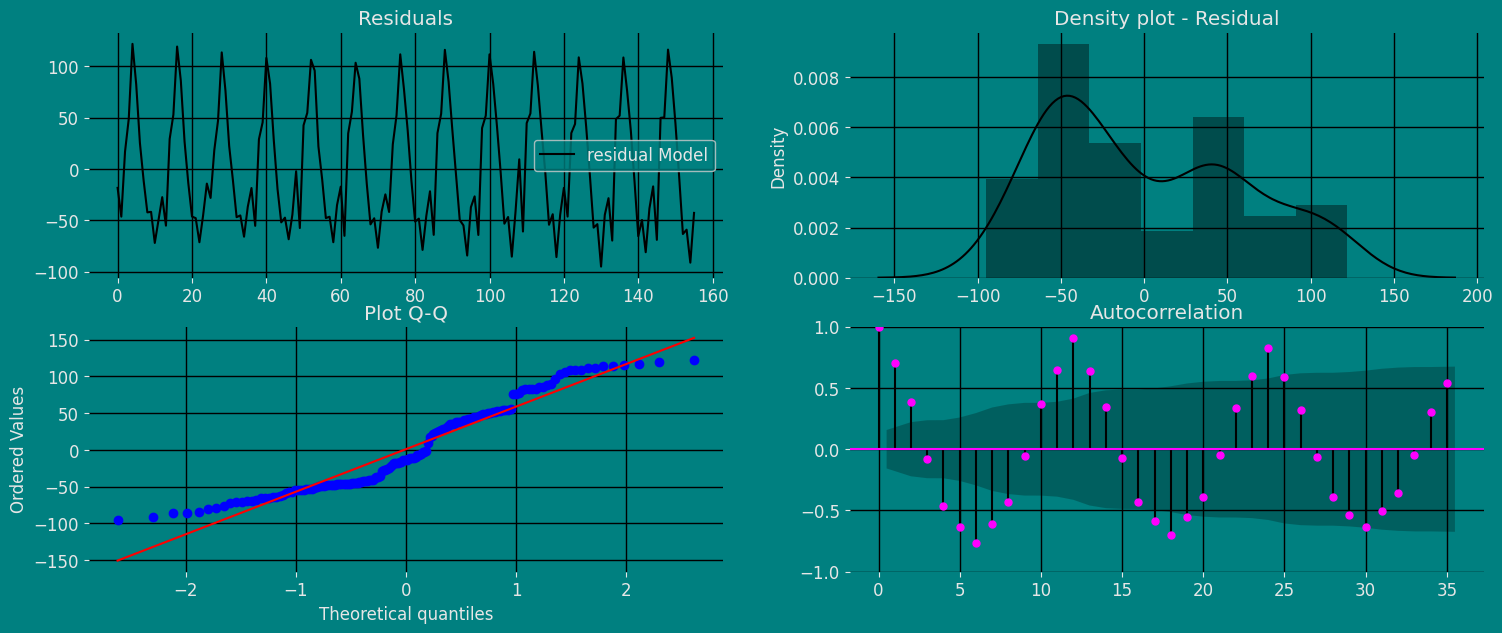

In [ ]:
import scipy.stats as stats

fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
Y_hat = sf.forecast(horizon, fitted=True)
Y_hat

,ds,DynamicTheta
unique_id,,
1,1975-01-01,838.531555
1,1975-02-01,800.154968
1,1975-03-01,893.430786
...,...,...
1,1975-10-01,815.959351
1,1975-11-01,786.716431
1,1975-12-01,823.539368


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,DynamicTheta
unique_id,,,
1,1962-01-01,589.0,607.247131
1,1962-02-01,561.0,607.247131
1,1962-03-01,640.0,622.859802
1,1962-04-01,656.0,606.987793
1,1962-05-01,727.0,605.021179


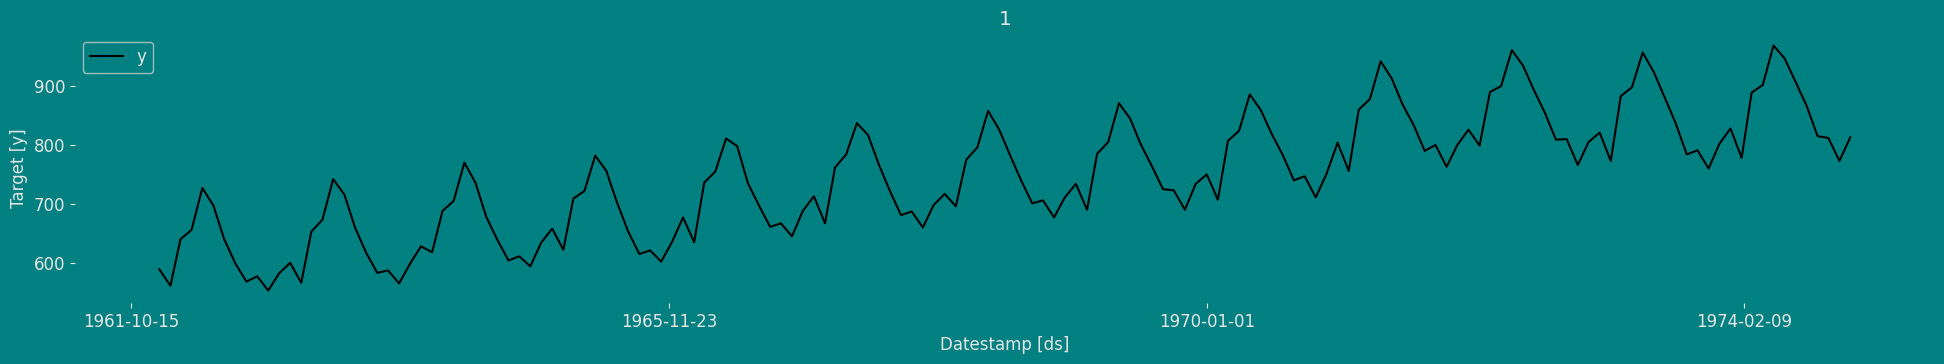

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(h=horizon, level=[95])

,ds,DynamicTheta,DynamicTheta-lo-95,DynamicTheta-hi-95
unique_id,,,,
1,1975-01-01,838.531555,741.237366,954.407166
1,1975-02-01,800.154968,640.697327,945.673157
1,1975-03-01,893.430786,703.900635,1065.418579
...,...,...,...,...
1,1975-10-01,815.959351,536.423035,1086.643677
1,1975-11-01,786.716431,484.476562,1033.687012
1,1975-12-01,823.539368,509.187408,1104.107788


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,DynamicTheta
0,1,1975-01-01,838.531555
1,1,1975-02-01,800.154968
2,1,1975-03-01,893.430786
...,...,...,...
9,1,1975-10-01,815.959351
10,1,1975-11-01,786.716431
11,1,1975-12-01,823.539368


In [ ]:
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,DynamicTheta
0,1975-01-01,834,1,838.531555
1,1975-02-01,782,1,800.154968
2,1975-03-01,892,1,893.430786
...,...,...,...,...
9,1975-10-01,827,1,815.959351
10,1975-11-01,797,1,786.716431
11,1975-12-01,843,1,823.539368


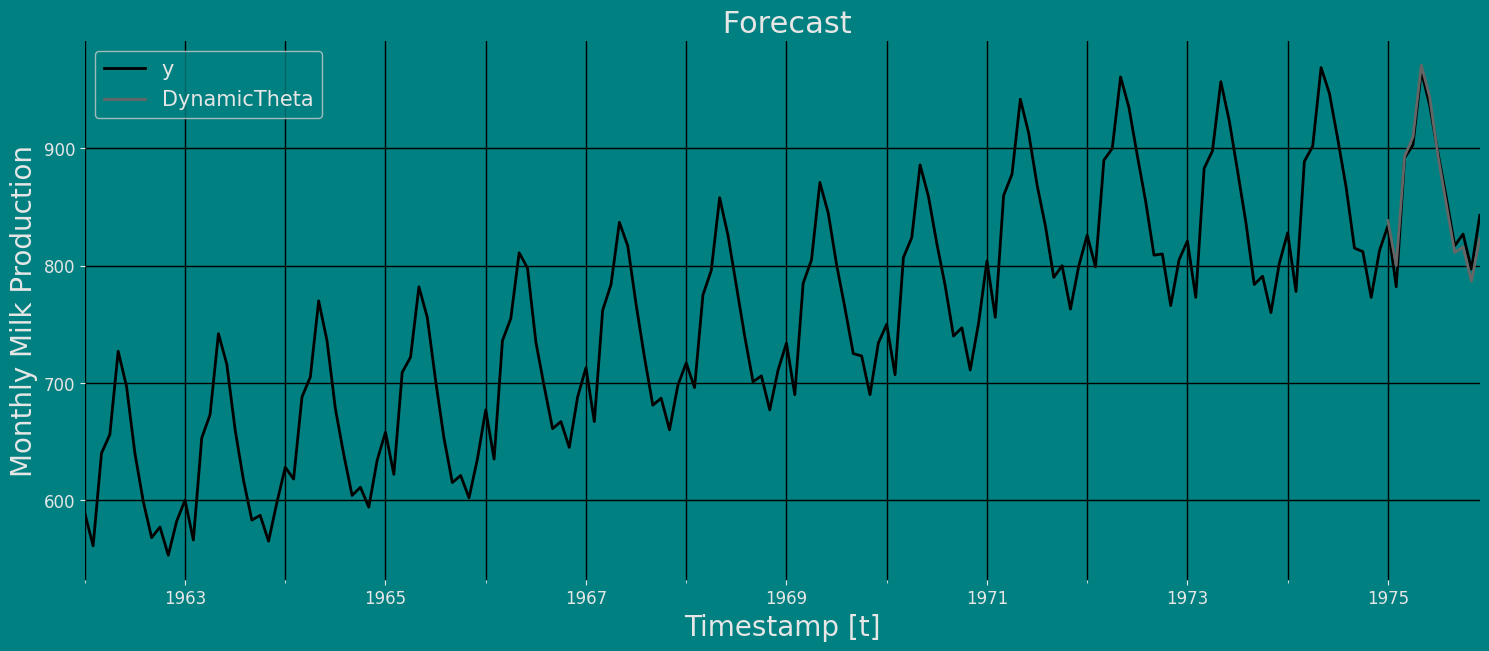

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "DynamicTheta"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly Milk Production', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon) 

,ds,DynamicTheta
unique_id,,
1,1975-01-01,838.531555
1,1975-02-01,800.154968
1,1975-03-01,893.430786
...,...,...
1,1975-10-01,815.959351
1,1975-11-01,786.716431
1,1975-12-01,823.539368


In [ ]:
forecast_df = sf.predict(h=horizon, level=[80,95]) 

forecast_df

,ds,DynamicTheta,DynamicTheta-lo-80,DynamicTheta-hi-80,DynamicTheta-lo-95,DynamicTheta-hi-95
unique_id,,,,,,
1,1975-01-01,838.531555,765.423828,927.285400,741.237366,954.407166
1,1975-02-01,800.154968,701.099854,899.316223,640.697327,945.673157
1,1975-03-01,893.430786,758.326416,1007.631287,703.900635,1065.418579
...,...,...,...,...,...,...
1,1975-10-01,815.959351,608.699524,992.552856,536.423035,1086.643677
1,1975-11-01,786.716431,558.429626,970.648560,484.476562,1033.687012
1,1975-12-01,823.539368,588.707153,1031.565063,509.187408,1104.107788


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
pd.concat([df, forecast_df]).set_index('ds')

,y,unique_id,DynamicTheta,DynamicTheta-lo-80,DynamicTheta-hi-80,DynamicTheta-lo-95,DynamicTheta-hi-95
ds,,,,,,,
1962-01-01,589.0,1.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,1.0,NaN,NaN,NaN,NaN,NaN
1962-03-01,640.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1975-10-01,NaN,NaN,815.959351,608.699524,992.552856,536.423035,1086.643677
1975-11-01,NaN,NaN,786.716431,558.429626,970.648560,484.476562,1033.687012
1975-12-01,NaN,NaN,823.539368,588.707153,1031.565063,509.187408,1104.107788


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

In [ ]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=3 , )
    colors = ['green', "lime"]
    ax.fill_between(df_plot.index, 
                df_plot['DynamicTheta-lo-80'], 
                df_plot['DynamicTheta-lo-80'],
                alpha=.20,
                color='orange',
                label='DynamicTheta_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['DynamicTheta-lo-95'], 
                df_plot['DynamicTheta-hi-95'],
                alpha=.3,
                color='lime',
                label='DynamicTheta_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Montly Mil Production", fontsize=20)
    ax.set_xlabel('Month-Days', fontsize=20)
    ax.legend(prop={'size': 20})
    ax.grid(True)
    plt.show()

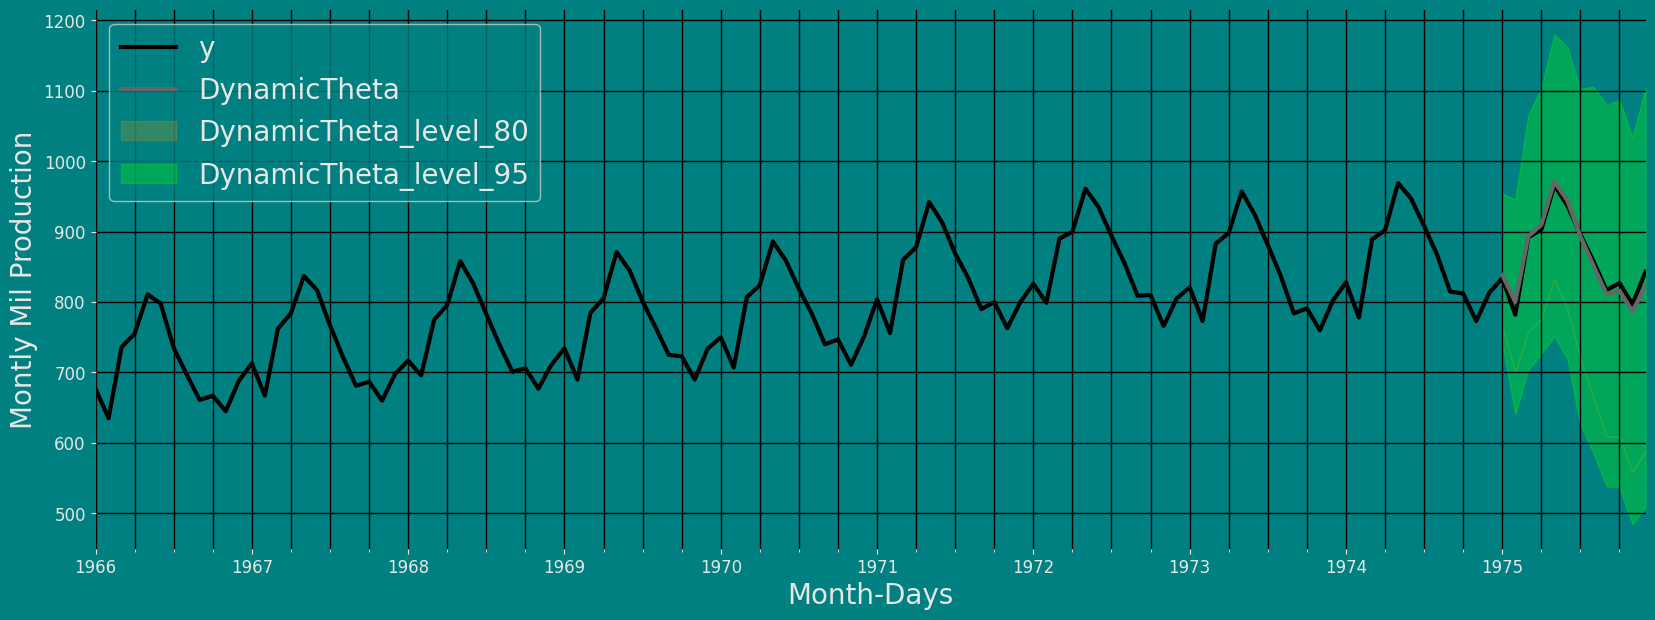

In [ ]:
plot_forecasts(train, test, forecast_df, models=['DynamicTheta'])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

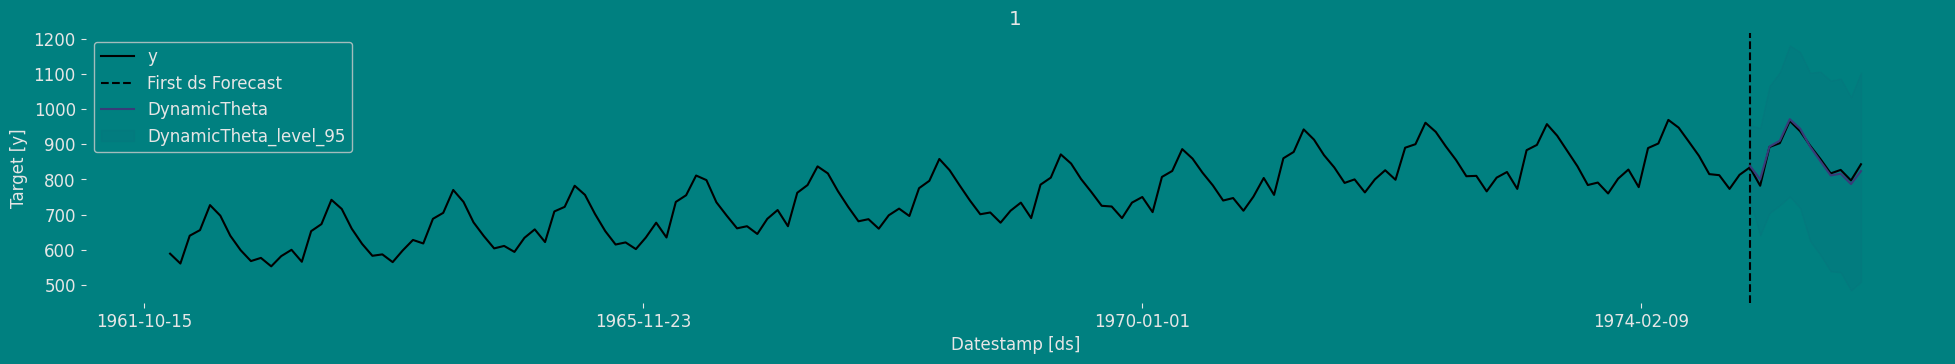

In [ ]:
sf.plot(df, forecast_df, level=[95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,DynamicTheta
unique_id,,,,
1,1972-01-01,1971-12-01,826.0,827.107239
1,1972-02-01,1971-12-01,799.0,789.924194
1,1972-03-01,1971-12-01,890.0,879.664429
...,...,...,...,...
1,1974-10-01,1973-12-01,812.0,804.398560
1,1974-11-01,1973-12-01,773.0,775.329285
1,1974-12-01,1973-12-01,813.0,811.767639


## Model Evaluation <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `Dynamic Standard Theta model`.

In [ ]:
rmse = rmse(crossvalidation_df['actual'], crossvalidation_df["DynamicTheta"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  12.610596


As you have noticed, we have used the cross validation results to perform the evaluation of our model.

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics `MAE, MAPE, MASE, RMSE, SMAPE` to evaluate the `accuracy`.

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred, model):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                y_true[model].values, 
                                                y_hist['y'].values, seasonality=12)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [ ]:
evaluate_performace(train, test, Y_hat, model="DynamicTheta")

,mae,mape,mase,rmse,smape
DynamicTheta,8.182119,0.97361,0.367965,9.817624,0.974804


## Acknowledgements

We would like to thank [Naren Castellon](https://www.linkedin.com/in/naren-castellon-1541b8101/?originalSubdomain=pa) for writing this tutorial.

## References <a class="anchor" id="references"></a>

1. Kostas I. Nikolopoulos, Dimitrios D. Thomakos. Forecasting with the Theta Method-Theory and Applications. 2019 John Wiley & Sons Ltd.
2. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
3. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#autotheta).
4. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
5. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
6. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).